In [ ]:
# Setup
#Kaggle dataset link: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand/code?datasetId=511638&sortBy=voteCount

# common:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

# for ML:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
! pip install eli5
import eli5 # Feature importance evaluation


# Mount Google Drive for file access
from google.colab import drive
drive.mount('/content/gdrive')

# load data:
file_path = "/content/gdrive/My Drive/Data Science/Projects/Housing Cancellation/hotel_bookings.csv"
full_data = pd.read_csv(file_path)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107747 sha256=67450785c1015975391d3ed58cf52c221f78d9d9c43ffdec79ab4097813db9e1
  Stored in directory: /root/.cache/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5
Mounted at /content/gdrive


In [ ]:
# Option to show all the columns
pd.set_option('display.max_columns', None)

# A bit of data inspection and cleanup, I did most of the inspectin seperately
full_data.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
# Checking data shape, which will later be used for comparison after data cleaning
old = full_data.shape
print(old)

(119390, 32)


In [ ]:
# check for missing values
full_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

We can see that there are 3 attributes with null values: country, agent, and company. These null values will need to be taken care of before we enter to the next phase of the analysis.

In [ ]:
# Replace missing values:
# agent: If no agency is given, booking was most likely made without one.
# company: If none given, it was most likely private.
# rest schould be self-explanatory.
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
full_data_cln = full_data.fillna(nan_replacements)

# "meal" contains values "Undefined", which is equal to SC - this information was retrived from the original data
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entries with 0 adults, 0 children and 0 babies.
# I'm dropping these entries with no guests by identifying the index of these entries.
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

In [ ]:
# Checking data shape after initial cleaning, comparing before and after
print("Initial DF Shape:", old)
print("New DF Shape:", full_data_cln.shape)

Initial DF Shape: (119390, 32)
New DF Shape: (119210, 32)


In [ ]:
# After cleaning, separate Resort and City hotel
# To know the acutal visitor numbers, only bookings that were not canceled are included

rh = full_data_cln.loc[(full_data_cln["hotel"]=="Resort Hotel")&(full_data_cln["is_canceled"]==0)]
ch = full_data_cln.loc[(full_data_cln["hotel"]=="City Hotel")&(full_data_cln["is_canceled"]==0)]

print("Resort Hotel Shape:", rh.shape)
print("City Hotel Shape:", ch.shape)

Resort Hotel Shape: (28927, 32)
City Hotel Shape: (46084, 32)


**1. Where are all the guests from?**

In [ ]:
#Get number of acutal guests by country, at the aggregated level
country_data = pd.DataFrame(full_data_cln.loc[full_data_cln["is_canceled"]==0]["country"].value_counts())

#Renaming the "country" column to "number of guests"
country_data.rename(columns={"country": "Number of Guests"}, inplace=True)

#Get number of total guests
total_guests = country_data["Number of Guests"].sum()

#Creating a new column showing the percentages
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)

#Because the country was initially index, we want to add a new country column that can be used as an attribute
country_data["country"] = country_data.index

#Let's also group countries that have less than 1% as Other
country_data.loc[country_data["Guests in %"] < 1, "country"] = "Other"

#Let's plot out the pie chart to see how it looks like
fig = px.pie(country_data,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

In [ ]:
# Representing the same data, but on map
guest_map = px.choropleth(country_data,
                    locations=country_data.index,
                    color=country_data["Guests in %"],
                    hover_name=country_data.index,
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Home country of guests")
guest_map.show()

People from all over the world are staying in these two hotels. Most guests are from Portugal and other countries in Europe.

**How much do guests pay per night?**

In [ ]:
#ADR: Average Daily Rate. When looking at this attribute, we only consider the average price for adults and children. Kids are excluded
rh["adr_pp"] = rh["adr"] / (rh["adults"] + rh["children"])
ch["adr_pp"] = ch["adr"] / (ch["adults"] + ch["children"])

<ipython-input-10-bbd621086208>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-10-bbd621086208>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Let's check the average price for resort hotels and city hotels separately
print("From all non-canceled bookings, across all room types and meals, the average prices are:")
print("Resort hotel: {:.2f} € per night per person".format(rh["adr_pp"].mean()))
print("City hotel: {:.2f} € per night per person".format(ch["adr_pp"].mean()))

From all non-canceled bookings, across all room types and meals, the average prices are:
Resort hotel: 47.49 € per night per person
City hotel: 59.27 € per night per person


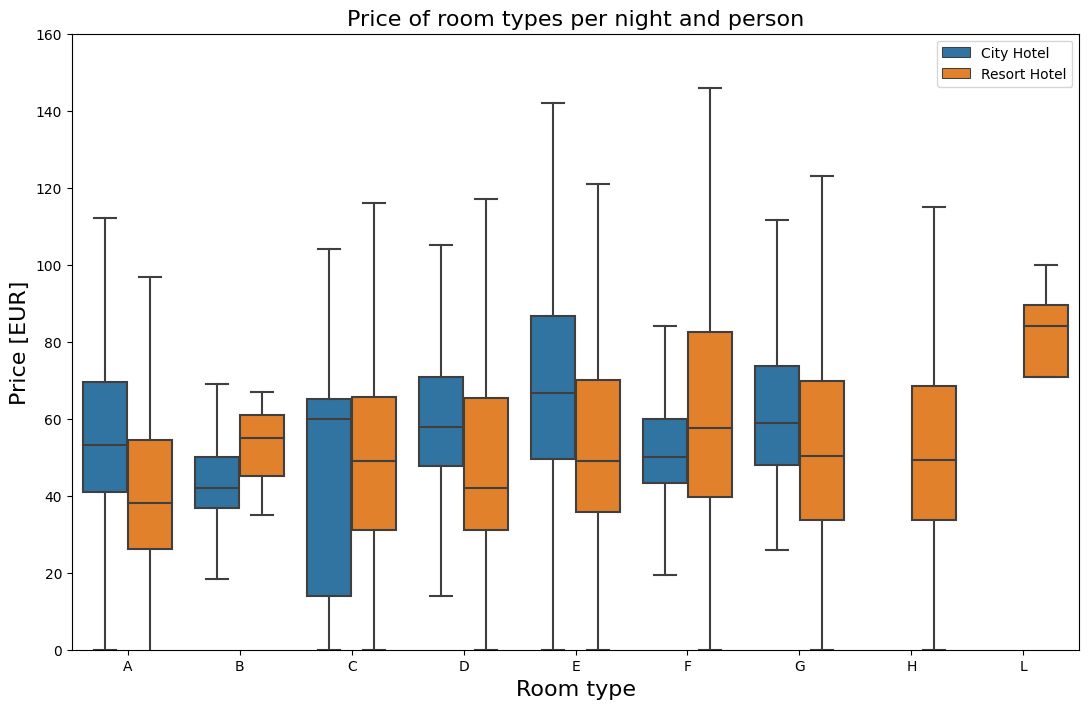

In [ ]:
#Let's use a box plot to visualize the distribution of the average prices across resort hotel vs. city hotel

#1. we add adr_pp as an attribute to the original dataframe
full_data_cln["adr_pp"] = full_data_cln["adr"] / (full_data_cln["adults"] + full_data_cln["children"])

#2. we filter for non-canceled entries
full_data_guests = full_data_cln.loc[full_data_cln["is_canceled"] == 0]

#3. we select the desired data points for the box plot - room prices
room_prices = full_data_guests[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")

#4. let's plot out the distribution through box plot
plt.figure(figsize=(13,8))

sns.boxplot(x="reserved_room_type",
            y="adr_pp",
            hue="hotel",
            data=room_prices,
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)

plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show()


The above figure shows the average price per room, depending on its type and the standard deviation.

Note that as there is no information on the difference between room types across hotels (b/t RH and CH), the analysis assumes that the room types are the same.

**3. How does the price vary per night over the year?**

<ipython-input-13-7cf742e4219b>:10: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.




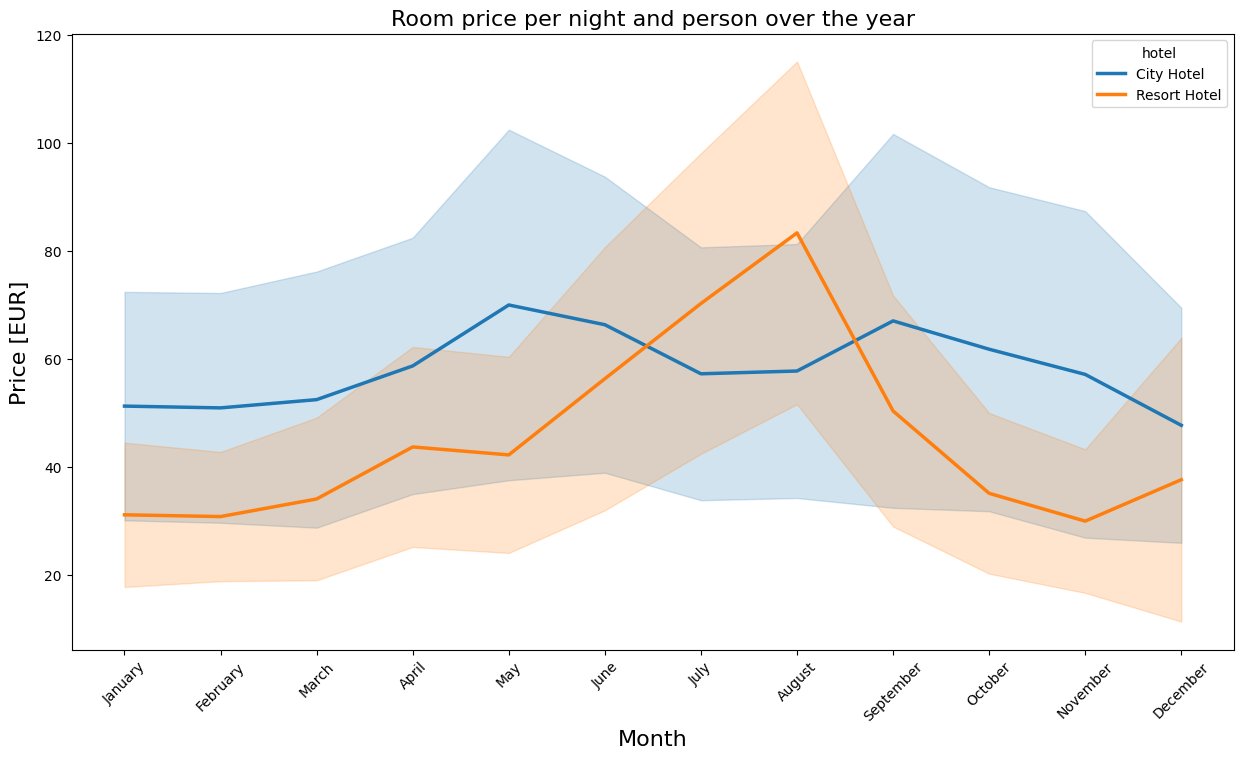

In [ ]:
#grabbing the data from full_data_guests df
room_prices_monthly = full_data_guests[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")

#ordering the month
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
room_prices_monthly["arrival_date_month"] = pd.Categorical(room_prices_monthly["arrival_date_month"], categories=month_order, ordered=True)

#lineplot with standard deviation
plt.figure(figsize=(15, 8))
sns.lineplot(x = "arrival_date_month", y="adr_pp", hue="hotel", data=room_prices_monthly,
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()

As illustrated by the plot above, we can observe the following trends:
1. Summer season (July to September) has a higher price per night compared to the other months
2. Resort hotel peaks for the month of August, while City hotel peaks during May and September. One explanation could be that people tend to go to resorts with their family, which is during August/September. Similarly, City hotels might've lowered their ticket price to attract more customers during peak resort travelling season.

**Which are the most busy months?**

In [ ]:
#Let's check if the number of months are consistent across the years
list(rh.groupby("arrival_date_year")["arrival_date_month"].unique())

[array(['July', 'August', 'September', 'October', 'November', 'December'],
       dtype=object),
 array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
        'August', 'September', 'October', 'November', 'December'],
       dtype=object),
 array(['January', 'February', 'March', 'April', 'May', 'August', 'July',
        'June'], dtype=object)]

In [ ]:
#Let's use the rh and ch dataframes that we've prepared
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = ch.groupby("arrival_date_month")["hotel"].count()


resort_guest_data = pd.DataFrame({
    "month": list(resort_guests_monthly.index),
    "hotel": "Resort hotel",
    "guests": list(resort_guests_monthly.values)
})

city_guest_data = pd.DataFrame({
    'month': list(city_guests_monthly.index),
    "hotel": "City hotel",
    "guests": list(city_guests_monthly.values)
})

#Ignoring index since it doesn't have any useful information
full_guest_data = pd.concat([resort_guest_data, city_guest_data], ignore_index=True)

#Order by month, by using pd.Categorical and pre-defined "month_order"
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=month_order, ordered=True)

#Since the number of months are not consistent across the years- July and August are across 3 years while the other months are only across 2 years, we will need to normalize the months.
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"), "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")), "guests"] /= 2

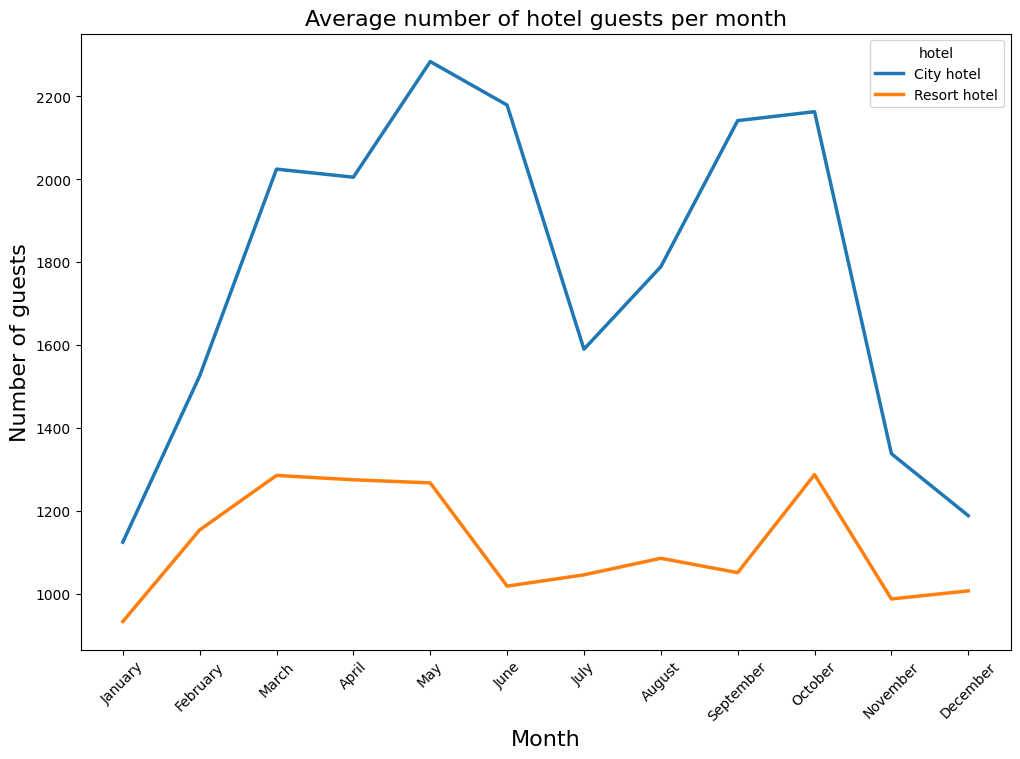

In [ ]:
#Let's plot the average number of hotel guests per month, across the 3 years
plt.figure(figsize=(12, 8))

sns.lineplot(x="month", y="guests", hue="hotel", data=full_guest_data, hue_order=["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

The City hotel has more guests during spring and autumn, which is also when the prices are the highest. Despite the prices being lower during June and July, the number of guests are also lower.

The Resort hotel's number declines from June to July, which is when the price is the highest.

For both hotels, we see a decline in the winter.

**How long do people stay at the hotels?**

In [ ]:
#Let's first determine the total number of nights that the visitors have stayed for both hotels
rh["total_nights"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]
ch["total_nights"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]

#By indexing we are sorting from the smallest to the largest
num_nights_rh = list(rh["total_nights"].value_counts().index)
num_bookings_rh = list(rh["total_nights"].value_counts())
#Converting to % of total data across the years
perc_bookings_rh = rh["total_nights"].value_counts() / sum(num_bookings_rh) * 100

num_nights_ch = list(ch["total_nights"].value_counts().index)
num_bookings_ch = list(ch["total_nights"].value_counts())
#Converting to % of total data across the years
perc_bookings_ch = ch["total_nights"].value_counts() / sum(num_bookings_ch) * 100

rh_nights = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": num_nights_rh,
                           "perc_num_bookings": perc_bookings_rh})

ch_nights = pd.DataFrame({"hotel": "City hotel",
                          "num_nights": num_nights_ch,
                          "perc_num_bookings": perc_bookings_ch})

nights_data = pd.concat([rh_nights, ch_nights], ignore_index=True)


<ipython-input-17-d4fed5d3a8a7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-17-d4fed5d3a8a7>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



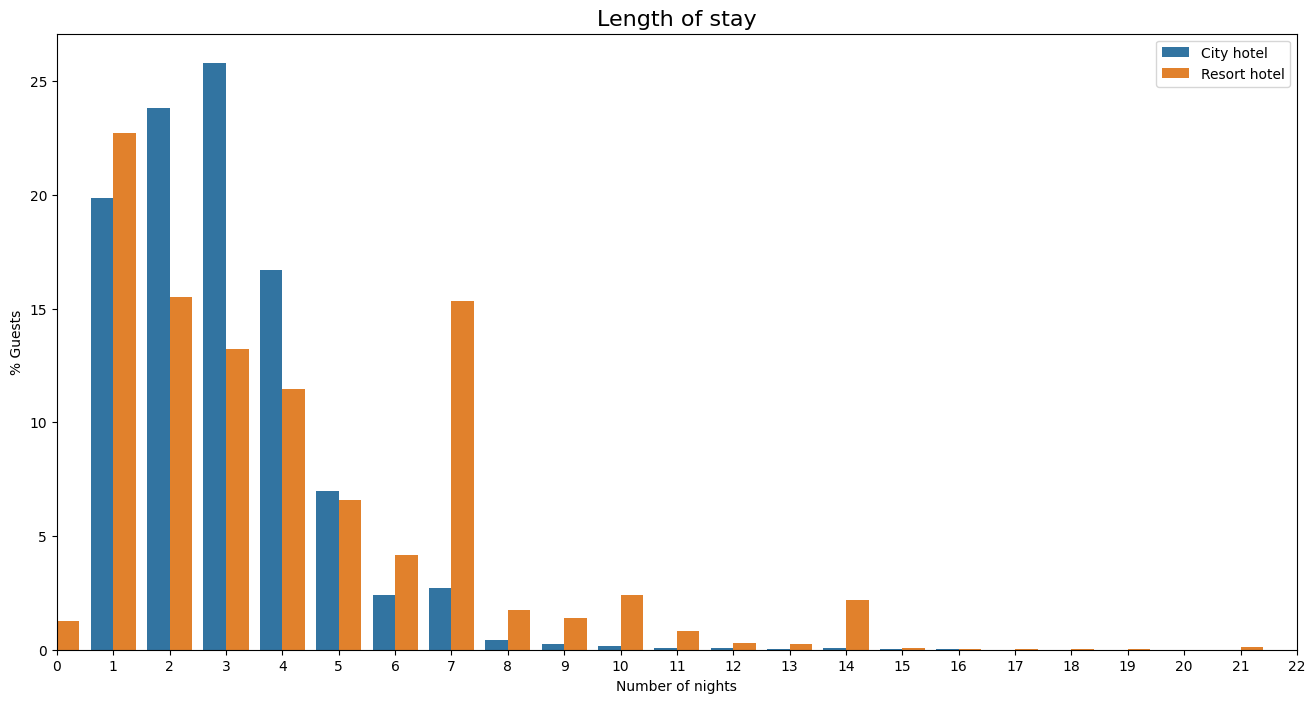

In [ ]:
#Default figure size
plt.figure(figsize=(16, 8))

#setting up the seaborn barplot
sns.barplot(x="num_nights", y="perc_num_bookings", hue="hotel", data = nights_data, hue_order = ["City hotel", "Resort hotel"])
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights")
plt.ylabel("% Guests")
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()

In [ ]:
#finding the average # of nights for resort hotels
rh_avg_nights = sum(list(rh_nights["num_nights"] * rh_nights["perc_num_bookings"]/100))
ch_avg_nights = sum(list(ch_nights["num_nights"] * ch_nights["perc_num_bookings"]/100))

print(f"The average number of nights for Resort hotel is: {rh_avg_nights:.2f} nights, with the maximum of {rh_nights['num_nights'].max()} nights")
print(f"THe average number of nights for City hotel is: {ch_avg_nights:.2f} nights, with the maximum of {ch_nights['num_nights'].max()} nights")

The average number of nights for Resort hotel is: 4.14 nights, with the maximum of 69 nights
THe average number of nights for City hotel is: 2.92 nights, with the maximum of 48 nights


For the City hotel, trend shows a preference for 1-4 nights.
For the Resort hotel, trend shows a preference for 1-4 nights as well, but we can also see that 7 nights is also very popular.

**Booking by market segment**

In [ ]:
#Let's illustrate the market segments in a pie chart, note that this data includes cancelled entries
market_segments = full_data_cln["market_segment"].value_counts()

fig = px.pie(market_segments,
        values=market_segments.values,
        names=market_segments.index,
        title = "Bookings per market segment",
        template = "seaborn")

#adding series label and rotating the pie chart 90 degrees counter-clockwise
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

The top market segment is through Online TA, with Oflline TA/TO and Groups in second and third place respectively.

**Let's look at the Average Daily Rate by market segment and room**

<ipython-input-21-8dbefb796254>:3: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.




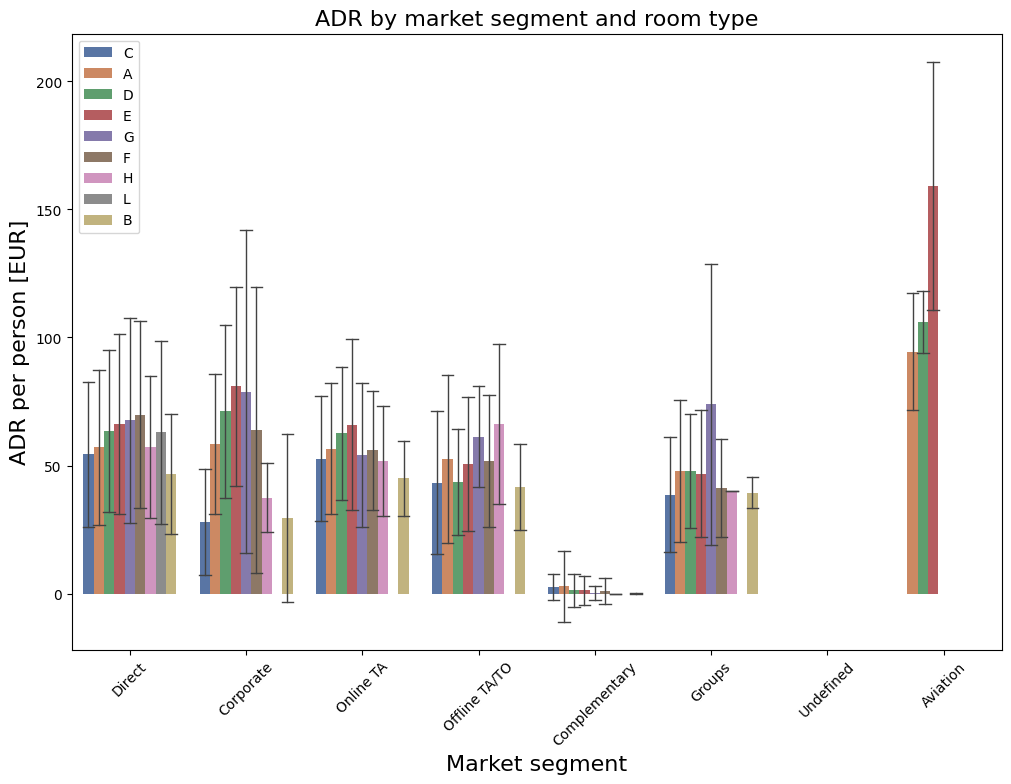

In [ ]:
plt.figure(figsize=(12,8))

sns.barplot(data=full_data_cln,
            x="market_segment",
            y="adr_pp",
            hue = "reserved_room_type",
            ci = "sd",
            errwidth = 1,
            palette="deep",
            capsize=0.1)

plt.title("ADR by market segment and room type", fontsize=16)
plt.xlabel("Market segment", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("ADR per person [EUR]", fontsize=16)
plt.legend(loc="upper left")
plt.show()

Looks like on average, Groups pay the lowest rate, while Aviation gets the highest rate, approximately twice as much. What causes Aviation to be higher?

In [ ]:
#Looking at the data summary for for Aviation vs. Non-Aviation
segment_list = ["is_canceled", "lead_time", "adults", "adr_pp"]

Aviation_segment = full_data_cln.loc[full_data_cln["market_segment"] == "Aviation"][segment_list].describe()
Non_aviation_segment = full_data_cln.loc[~(full_data_cln["market_segment"] == "Aviation")][segment_list].describe()

In [ ]:
Aviation_segment

,is_canceled,lead_time,adults,adr_pp
count,235.000000,235.00000,235.000000,235.000000
mean,0.221277,4.47234,1.012766,100.270979
std,0.415992,4.61629,0.112503,20.376689
min,0.000000,0.00000,1.000000,0.000000
25%,0.000000,1.00000,1.000000,95.000000
50%,0.000000,3.00000,1.000000,95.000000
75%,0.000000,6.00000,1.000000,110.000000
max,1.000000,23.00000,2.000000,193.500000


In [ ]:
Non_aviation_segment

,is_canceled,lead_time,adults,adr_pp
count,118975.000000,118975.000000,118975.000000,118971.000000
mean,0.371061,104.306031,1.860878,55.038212
std,0.483091,106.888885,0.574499,29.016998
min,0.000000,0.000000,0.000000,-3.190000
25%,0.000000,18.000000,2.000000,37.440000
50%,0.000000,69.000000,2.000000,49.500000
75%,1.000000,161.000000,2.000000,66.000000
max,1.000000,737.000000,55.000000,2700.000000


The above tells us that:
1. Aviation segment has significantly shorter lead_time (4 days vs. average of 104 days)
2. On average, 1 adult per room, which means that there are more total rooms required compared to families.

**How many bookings were cancelled?**

In [ ]:
# For is_canceled, 1 = canceled, 0 = not canceled. By default, value_counts will only count the rows where the value is = 1.
total_cancelations = full_data_cln["is_canceled"].sum()
totalp_cancelations = total_cancelations / full_data_cln["is_canceled"].shape[0] * 100

rh_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"]["is_canceled"].sum()
rhp_cancelations = rh_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"].shape[0] * 100

ch_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"]["is_canceled"].sum()
chp_cancelations = ch_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"].shape[0] * 100

In [ ]:
# Let's return the numerical figures to see how the cancellation happened
print(f"Total Bookings cancelled: {total_cancelations:,}, {totalp_cancelations:.0f}%")
print(f"Total Resort Hotel bookings cancelled: {rh_cancelations:,}, {rhp_cancelations:.0f}%")
print(f"Total City Hotel bookings cancelled: {ch_cancelations:,}, {chp_cancelations:.0f}%")

Total Bookings cancelled: 44,199, 37%
Total Resort Hotel bookings cancelled: 11,120, 28%
Total City Hotel bookings cancelled: 33,079, 42%


**Which month have the highest number of cancelations?**

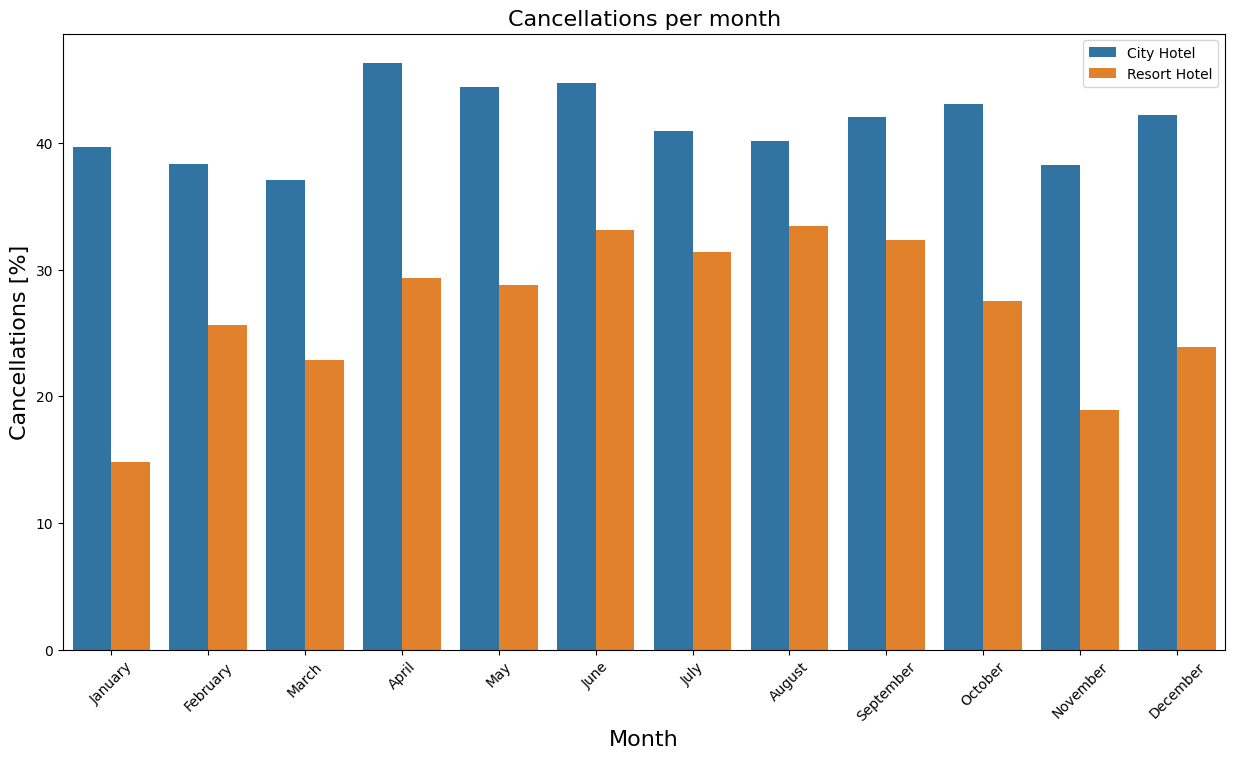

In [ ]:
# Aggregating bookings: resort hotel and city hotel by month, and identifying whether these were these bookings were cancelled
rh_bookings_per_month = full_data_cln.loc[full_data_cln["hotel"]=="Resort Hotel"].groupby("arrival_date_month")["hotel"].count()
rh_canceled_per_month = full_data_cln.loc[(full_data_cln["hotel"]=="Resort Hotel") & (full_data_cln["is_canceled"] == 1)].groupby("arrival_date_month")["hotel"].count()

ch_bookings_per_month = full_data_cln.loc[full_data_cln["hotel"]=="City Hotel"].groupby("arrival_date_month")["hotel"].count()
ch_canceled_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"] == 1)].groupby("arrival_date_month")["hotel"].count()

# Creating two separate DataFrames for Resort Hotel and City Hotel
rh_canceled_data = pd.DataFrame({
    "Hotel": "Resort Hotel",
    "Month": list(rh_bookings_per_month.index),
    "Bookings": list(rh_bookings_per_month.values),
    "Cancellations": list(rh_canceled_per_month.values)
})

ch_canceled_data = pd.DataFrame({
    "Hotel": "City Hotel",
    "Month": list(ch_bookings_per_month.index),
    "Bookings": list(ch_bookings_per_month.values),
    "Cancellations": list(ch_canceled_per_month.values)
})

# Concatinate the rh and ch dataframes together
full_canceled_data = pd.concat([rh_canceled_data, ch_canceled_data], ignore_index=True)
full_canceled_data["cancel_percent"] = full_canceled_data["Cancellations"] / full_canceled_data["Bookings"] * 100
# Now let's reorder the month chronologically for plotting purposes
full_canceled_data['Month'] = pd.Categorical(full_canceled_data['Month'], categories=month_order, ordered=True)

# Plot:
plt.figure(figsize=(15, 8))
sns.barplot(x="Month", y="cancel_percent", hue="Hotel", hue_order=['City Hotel', 'Resort Hotel'], data=full_canceled_data)
plt.title("Cancellations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancellations [%]", fontsize=16)
plt.legend(loc='upper right')
plt.show()


For City Hotels, majority of the hotel cancellations are about 40% to 50%, while the Resort Hotels have a higher fluctuation, between 15% and 30%.

For the Resort Hotel, cancellations are higher in the summer, and lower in the winter.

**Predict Cancellations**

In [ ]:
# The first question to ask is, which numerical features are most important?

cancel_corr = full_data.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

Based on the output above, we can see that the top 5 important features are:
lead_time, total_of_special_requests, required_car_parking_spaces, booking_changes, and previous_cancellations.

It is important to note that:
1. booking_changes varies heavily and could be a potential leakage
2. days_in_waiting_list also varies heavily and can contribute to leakage
3. arrival_date_year has no significant contribution since there's only 3 years worth of data, and based on the EDA, we did not identify any annual trends

Thus, the above features / attributes will not be used in the prediction model.

Going through all the features again, another feature to exclude would be reservation_status.

In [ ]:
full_data['reservation_status'].value_counts()

Check-Out    75166
Canceled     43017
No-Show       1207
Name: reservation_status, dtype: int64

In [ ]:
# List of attributes that we DON"T want in the model, note that 'is_canceled' is the target, and is excluded
excluded = ['is_canceled', 'booking_changes', 'days_in_waiting_list', 'arrival_date_year', 'reservation_status', 'reservation_status_date', 'assigned_room_type', 'hotel']

# Seperating categorial and numerical data
cat_attributes = full_data.select_dtypes(include='object').columns.tolist()
num_attributes = full_data.select_dtypes(exclude='object').columns.tolist()

# Excluding the attributes that we DON'T want from the lists
for i in excluded:
  if i in num_attributes:
    num_attributes.remove(i)
  elif i in cat_attributes:
    cat_attributes.remove(i)

# Returning the total number of categorical and numerical attributes
print(f"Total number of Categorical Attributes: {len(cat_attributes)}")
print(f"Total number of Numerical Attributes: {len(num_attributes)}")

Total number of Categorical Attributes: 8
Total number of Numerical Attributes: 16


In [ ]:
# Separate features and predicted value
features = cat_attributes + num_attributes

X = full_data.drop(['is_canceled'], axis=1)[features]
y = full_data['is_canceled']

# Preprocess numerical features:
# For most numerical features, except the dates, it would make sense to set 0 as the fill value. For our dataset, there is no date missing.
num_transformer = SimpleImputer(strategy="constant")

# For the categorical features, we will fill N/As with unknown. We are also using onehotencoding for the categorical features
cat_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_attributes),
                                               ("cat", cat_transformer, cat_attributes)])

In [ ]:
# Defining the base model to test:
# the n_job = -1 here means that the computation will be dispatched on all the CPUs of the computer
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# Split data into k-folds for cross validation, and use shuffle for random distribution of data
# kfold of 4 means 75% train, 25% cross validation
kfolds = 4
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

In [ ]:
# # Preprocessing, fittng, and making predictions and scorings for every model:
# for name, model in base_models:

#   # Pack preprocessing of data and the model into a pipeline:
#   model_steps = Pipeline(steps=[('preprocessor', preprocessor),
#                          ('model', model)])

#   # Get cross validation score for each model:
#   cv_results = cross_val_score(model_steps,
#                                X, y,
#                                cv=split,
#                                scoring="accuracy",
#                                n_jobs=-1)

#   # Output:
#   min_score = round(min(cv_results), 4)
#   max_score = round(max(cv_results), 4)
#   mean_score = round(np.mean(cv_results), 4)
#   std_dev = round(np.std(cv_results), 4)
#   print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

Based on the accuracy scores above, we can see that RandomForest model performed the best, with an accuracy score of 0.8866.

Storing the values here temp, to save run-time:

DT_model cross validation accuarcy score: 0.8542 +/- 0.0014 (std) min: 0.8526, max: 0.8565


RF_model cross validation accuarcy score: 0.8866 +/- 0.0019 (std) min: 0.8849, max: 0.8899


LR_model cross validation accuarcy score: 0.8017 +/- 0.0027 (std) min: 0.799, max: 0.8048


XGB_model cross validation accuarcy score: 0.8696 +/- 0.0028 (std) min: 0.8666, max: 0.8738

In [ ]:
# Let's see if we can get a better score with some hyperparameter optimization
rf_model_enh = RandomForestClassifier(n_estimators=160,
                                      max_features=0.4,
                                      min_samples_split=2,
                                      n_jobs=-1,
                                      random_state=0)

split = KFold(n_splits=kfolds, shuffle=True, random_state=42)


model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', rf_model_enh)])

# # Get crossvalidation scores for the rf model:
# cv_results = cross_val_score (model_pipe,
#                               X, y,
#                               cv=split,
#                               scoring='accuracy',
#                               n_jobs=-1)

# # Output:
# min_score = round(min(cv_results), 4)
# max_score = round(max(cv_results), 4)
# mean_score = round(np.mean(cv_results), 4)
# std_dev = round(np.std(cv_results), 4)
# print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

We can see the hyperparameter optimization has increased the overall accuracy score, although minimal.

Storing the results here temp. to save run-time:


XGB_model cross validation accuarcy score: 0.8904 +/- 0.0024 (std) min: 0.8885, max: 0.8944


**Evaluate Feature Importance**

Previously we looked at the correlation of numerical features to the target ("is_canceled") field, but now let's look at the weight of each feature, in otherwords, how important is the feature to the prediction model?

In [ ]:
# fit model(pipeline) so values can be accessed:
model_pipe.fit(X,y)

# Names of all (encoded) features are needed. We will get the names of columns from One Hot Encoding
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names_out(input_features=cat_attributes))



In [ ]:
# Add num_features for full list. Order must be as in definition of X, where num_features are first
feat_imp_list = num_attributes + onehot_columns

feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)

feat_imp_df.head(10)

,feature,weight,std
0,lead_time,0.121400,0.014355
1,deposit_type_Non Refund,0.111441,0.105687
2,deposit_type_No Deposit,0.092556,0.104029
3,adr,0.072609,0.003771
4,country_PRT,0.063980,0.028412
5,agent,0.055125,0.010954
6,arrival_date_day_of_month,0.050415,0.001905
7,total_of_special_requests,0.048620,0.009926
8,arrival_date_week_number,0.044965,0.002005
9,market_segment_Online TA,0.034257,0.018111


Let's take a deeper look at the three most important features:
1. lead_time
2. deposit_type
3. adr

**lead_time:**

In [ ]:
full_data_cln['lead_time']

0         342
1         737
2           7
3          13
4          14
         ... 
119385     23
119386    102
119387     34
119388    109
119389    205
Name: lead_time, Length: 119210, dtype: int64

In [ ]:
full_data_cln.groupby('lead_time')['is_canceled'].describe()

,count,mean,std,min,25%,50%,75%,max
lead_time,,,,,,,,
0,6264.0,0.066571,0.249297,0.0,0.0,0.0,0.0,1.0
1,3445.0,0.092308,0.289502,0.0,0.0,0.0,0.0,1.0
2,2065.0,0.103148,0.304225,0.0,0.0,0.0,0.0,1.0
3,1815.0,0.100275,0.300450,0.0,0.0,0.0,0.0,1.0
4,1710.0,0.102339,0.303182,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
622,17.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
626,30.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
629,17.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


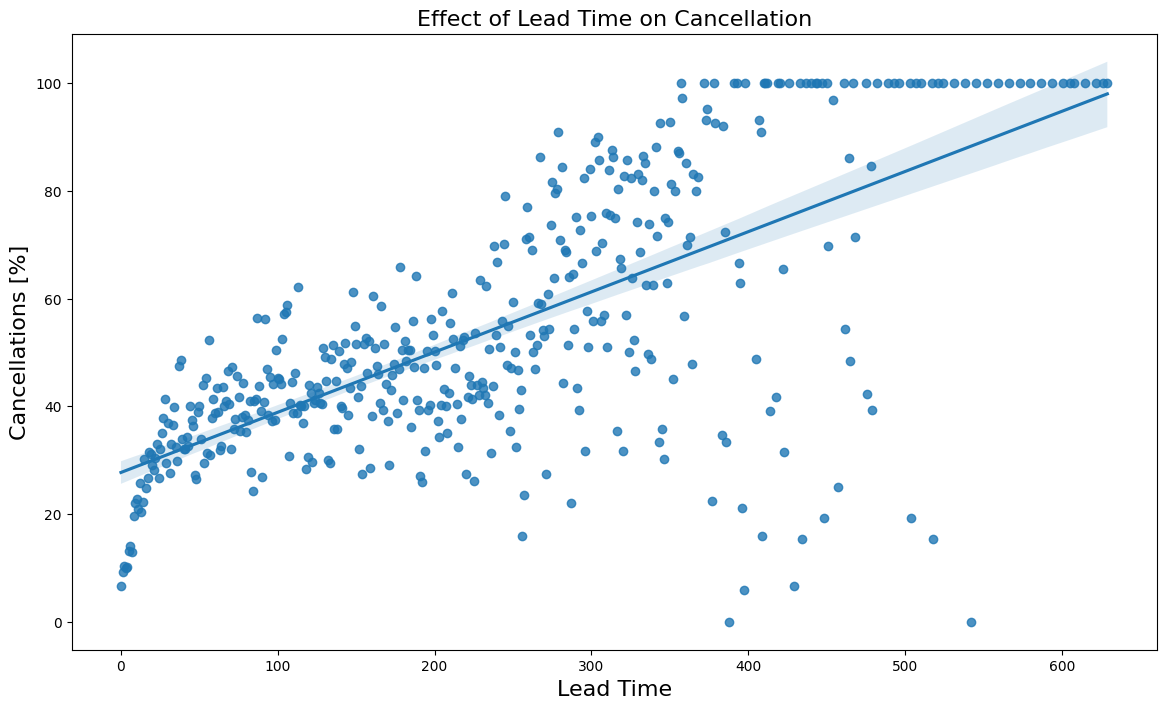

In [ ]:
# Group data for lead_time, and finding out what the mean % of cancellation is:
lead_cancel_data = full_data_cln.groupby('lead_time')['is_canceled'].describe()

# Here, we are looking at lead_times with more than 10 bookings for the plot:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data['count']>=10]

#show figure... note that since we are plotting for the % of cancellation, the mean is multipled by 100:
plt.figure(figsize = (14, 8))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10['mean']*100)
plt.title ("Effect of Lead Time on Cancellation", fontsize=16)
plt.xlabel("Lead Time", fontsize=16)
plt.ylabel("Cancellations [%]", fontsize=16)
plt.show()

Bookings made closer to the arrival date are rarely cancelled, but bookings made approximately over 1 year in advance are cancelled very often.

**Now let's look at deposit types**

Text(0, 0.5, 'cancellation [%]')

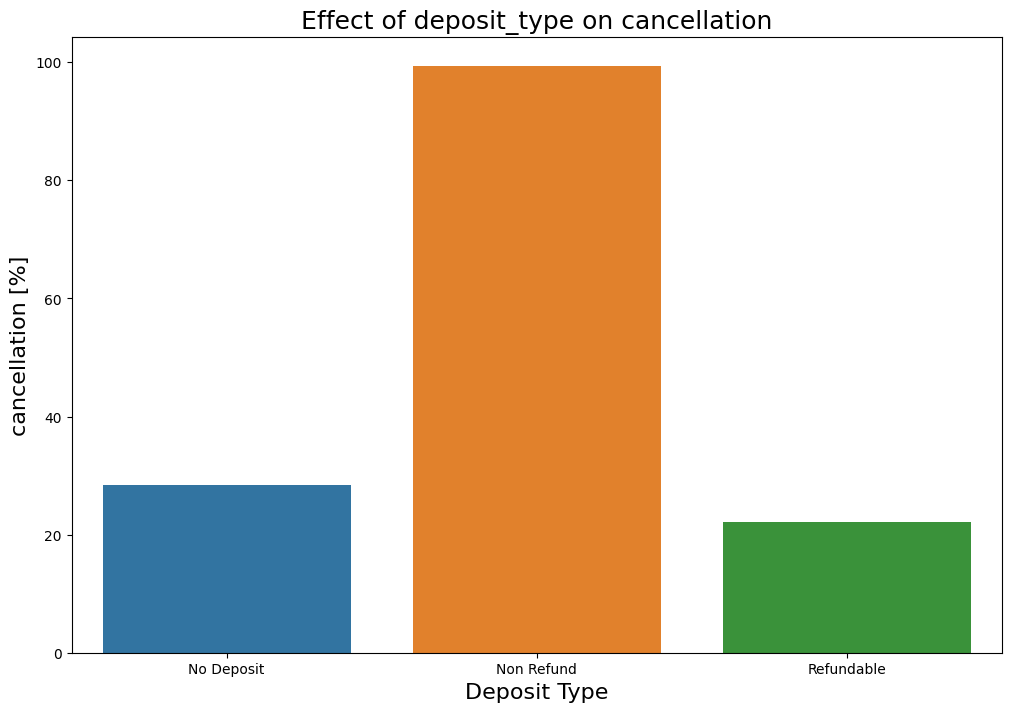

In [ ]:
# Again, similar what we've done with lead_time, we will groupby by the deposit_type and determine the cancellation percentage.
deposit_types = full_data_cln.groupby(['deposit_type'])["is_canceled"].describe()

# Plotting out the data
plt.figure(figsize=(12,8))
sns.barplot(data=deposit_types, x=deposit_types.index, y=deposit_types['mean']*100)
plt.title("Effect of deposit_type on cancellation", fontsize=18)
plt.xlabel("Deposit Type", fontsize=16)
plt.ylabel("cancellation [%]", fontsize=16)

Based on the plot it appears that Non-Refund has the highest % of cancellation... which doesn't really make sense. Let's further investigate the dataset. Is there something wrong?

In [ ]:
# Let's look at the original dataset, with the mean, instead of the mean % of cancellations
deposit_mean_data = full_data_cln.groupby('deposit_type').mean()
deposit_mean_data

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,adr_pp
deposit_type,,,,,,,,,,,,,,,,,,,,,
No Deposit,0.284020,88.841951,2016.173950,27.133208,15.815223,0.969615,2.555633,1.865806,0.118604,0.009085,0.035295,0.042044,0.154938,0.247030,78.745503,11.175874,1.518040,103.685436,0.071184,0.651726,55.233383
Non Refund,0.993624,212.908891,2016.031466,27.448619,15.595462,0.621718,2.091109,1.811407,0.000617,0.000000,0.004387,0.411462,0.010626,0.012477,47.480016,6.215809,7.992253,89.964017,0.000069,0.001782,54.520286
Refundable,0.222222,152.098765,2016.141975,20.932099,23.456790,0.975309,2.851852,1.907407,0.030864,0.000000,0.024691,0.000000,0.018519,0.592593,56.185185,133.666667,9.586420,76.209753,0.123457,0.141975,41.444239


Comparing Non-Refund to No-Deposit and Refundable:
1. Significantly higher lead_time
2. Significantly lower is_repeated_guest
3. Higher previous_cancellations
3. Lower booking_changes
4. Almost no total_of_special_requests

The above trends are suggesting that Non-Refund deposits are mostly Non-repeated guests, but has higher previous_cancellations? Which doesn't make sense... why would anyone that hasn't visited the hotels, book pay, and cancel repeatedly? Maybe we could attmept to run the RF model again without this feature and see how that will affect the model accuracy.

**Now let's look at the effect of ADR on cancellation**

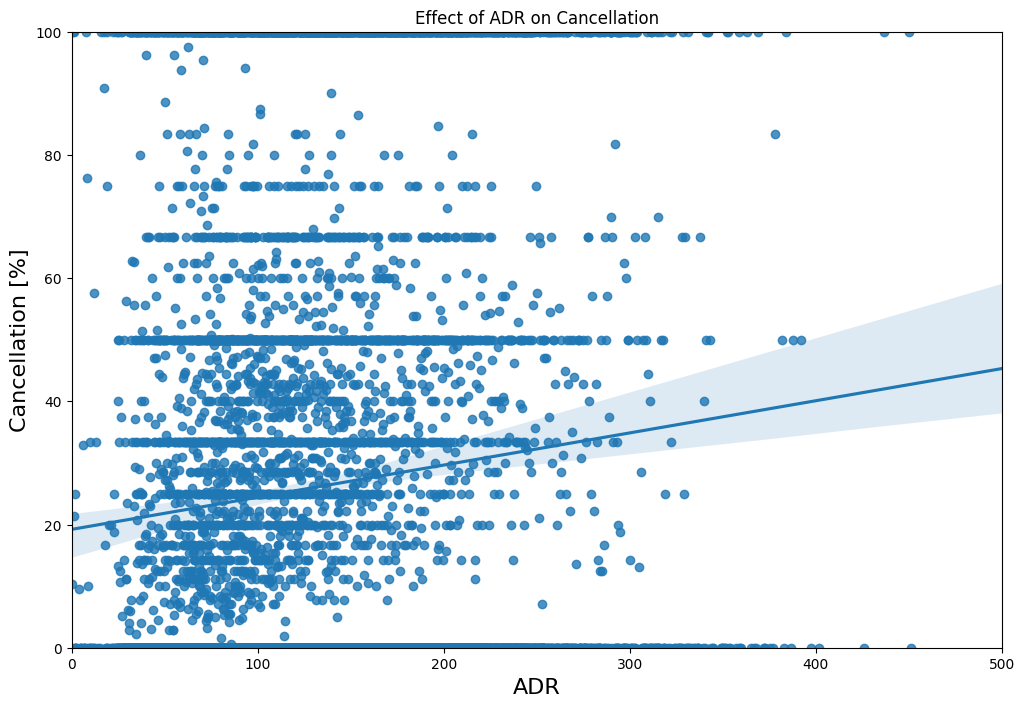

In [ ]:
# Group data for ADR:
adr_cancel_data = full_data_cln.groupby("adr")["is_canceled"].describe()

# Show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=adr_cancel_data.index, y=adr_cancel_data["mean"]*100)
plt.title("Effect of ADR on Cancellation")
plt.xlabel("ADR", fontsize=16)
plt.ylabel("Cancellation [%]", fontsize=16)
# Based on the first plot, the clusters were identifed to be with the X and y limits below:
plt.xlim(0, 500)
plt.ylim(0, 100)
plt.show()

In [ ]:
# Returning feature importance of the original RF model:
feat_imp_df.head(10)

,feature,weight,std
0,lead_time,0.121400,0.014355
1,deposit_type_Non Refund,0.111441,0.105687
2,deposit_type_No Deposit,0.092556,0.104029
3,adr,0.072609,0.003771
4,country_PRT,0.063980,0.028412
5,agent,0.055125,0.010954
6,arrival_date_day_of_month,0.050415,0.001905
7,total_of_special_requests,0.048620,0.009926
8,arrival_date_week_number,0.044965,0.002005
9,market_segment_Online TA,0.034257,0.018111


In [ ]:
# Now let's run the model without "Deposit_type" as an attribute

# Since deposit_type is a categorical feature, we only need to make changes to the cat_attributes. num_attributes stay the same.
cat_attributes_non_dep = cat_attributes.copy()
cat_attributes_non_dep.remove('deposit_type')

features_non_dep = cat_attributes_non_dep + num_attributes
X_non_dep = full_data.drop(["is_canceled"], axis=1)[features_non_dep]

# Bundle preorpcessing for numerical and acetgorical features:
preprocessor_non_dep = ColumnTransformer(transformers=[("num", num_transformer, num_attributes),
                                                       ("cat", cat_transformer, cat_attributes_non_dep)])

# Define model:
rf_model_non_dep = RandomForestClassifier(random_state=42)

kfolds=4
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor_non_dep),
                             ('model', rf_model_non_dep)])

cv_results = cross_val_score(model_pipe,
                             X_non_dep, y,
                             cv=split,
                             scoring='accuracy',
                             n_jobs=-1)

# Output the score with 4 decimal points:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)

print(f"RF model without the deposit_type as a feature, has cross validation accuracy score of: {mean_score} +/- {std_dev} (std), mean value of {min_score} max value of {max_score}")

RF model without the deposit_type as a feature, has cross validation accuracy score of: 0.8864 +/- 0.0022 (std), mean value of 0.8864 max value of 0.8899


RF model without the deposit_type as a feature, has cross validation accuracy score of: 0.8864 +/- 0.0022 (std), mean value of 0.8864 max value of 0.8899... which means that there is no significant improvement in the accuracy score by removing deposit_type as an attribute.